In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Simple function which takes a df and column as input and returns a df with dummy variables as output
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],drop_first=True,prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(column_name,axis=1)
    return df

#Function to show missing values
def missing_cols(df):
    cols = df.columns[df.isna().any()].tolist()
    print(f'Columns | Percentage missing')
    for columns in cols:
        percentage = round((sum(df[columns].isnull())/df.shape[0])*100,2)
        print(f'{columns} : {percentage}%')

#Plotting Categorical data
def categories_plot(df,col,xlabel='Values',size=(8,4)):
    y_train = df[col].value_counts().values
    x_train = df[col].value_counts().index.tolist()
    plt.figure(figsize=size)
    plt.title(col)
    sns.barplot(x_train,y_train)
    plt.xlabel(xlabel)
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('count')
    plt.show()

#Plotting numeric data
def numeric_plot(X,y,size=(10,6)):
    plt.figure(figsize=size)
    sns.scatterplot(x=X,y=y)
    plt.show

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
missing_cols(data)

Columns | Percentage missing
LotFrontage : 17.74%
Alley : 93.77%
MasVnrType : 0.55%
MasVnrArea : 0.55%
BsmtQual : 2.53%
BsmtCond : 2.53%
BsmtExposure : 2.6%
BsmtFinType1 : 2.53%
BsmtFinType2 : 2.6%
Electrical : 0.07%
FireplaceQu : 47.26%
GarageType : 5.55%
GarageYrBlt : 5.55%
GarageFinish : 5.55%
GarageQual : 5.55%
GarageCond : 5.55%
PoolQC : 99.52%
Fence : 80.75%
MiscFeature : 96.3%


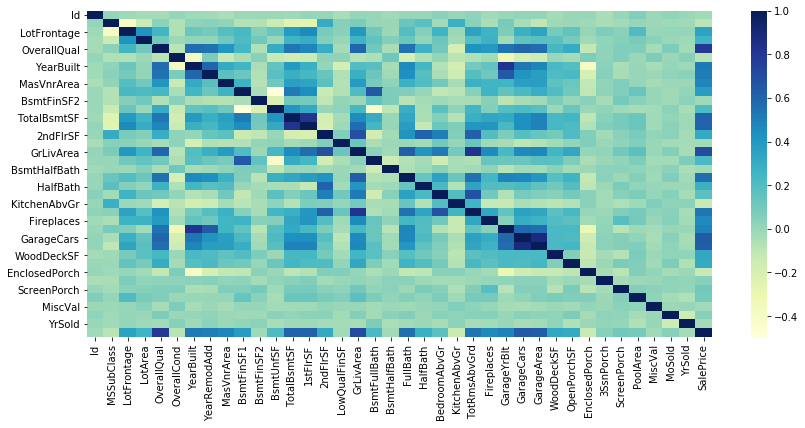

In [6]:
#Deleting data with <80% missing values
data = data.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)
holdout = holdout.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)
#Creating Correlation matrix 
corr_num = data.corr()
corr_num.describe()
#Plotting all correlations
plt.figure(figsize=(14,6))
sns.heatmap(corr_num,cmap='YlGnBu')
plt.show()


In [7]:
#We can see that some values are highly coorelated with each other I.e GarageArea and GarageCars
#One of these columns needs to be deleted, so we need to view their coorelations with SalePrice and delete the ones with less correlation with SalePrice
corr = corr_num['SalePrice'].abs().sort_values(ascending=False)
print(corr)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePr

In [8]:
data.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'],axis=1,inplace=True)
holdout.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'],axis=1,inplace=True)

In [9]:
data.select_dtypes(include=['int','float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

/home/mrutyunjaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


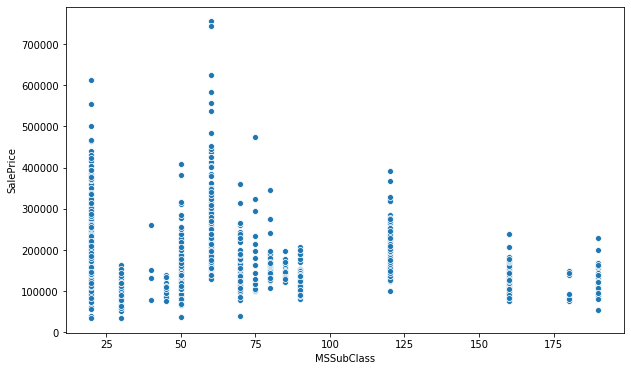

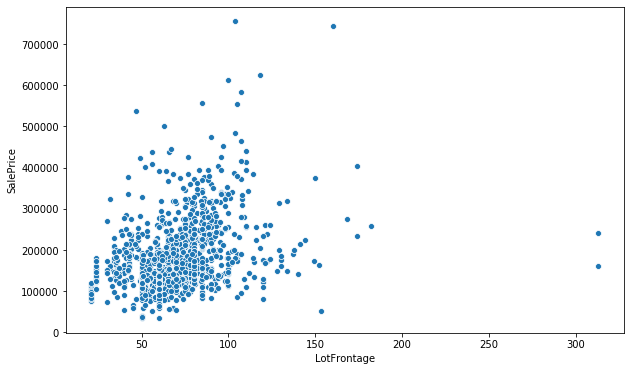

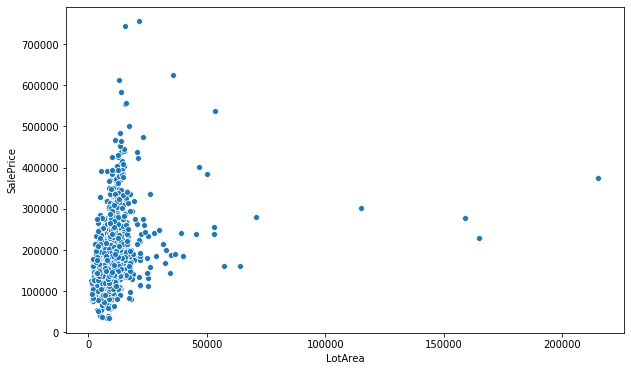

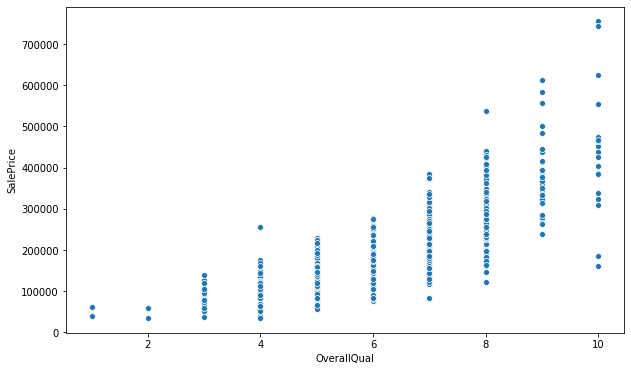

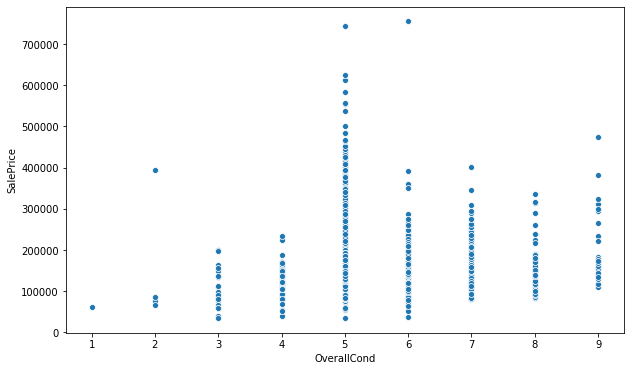

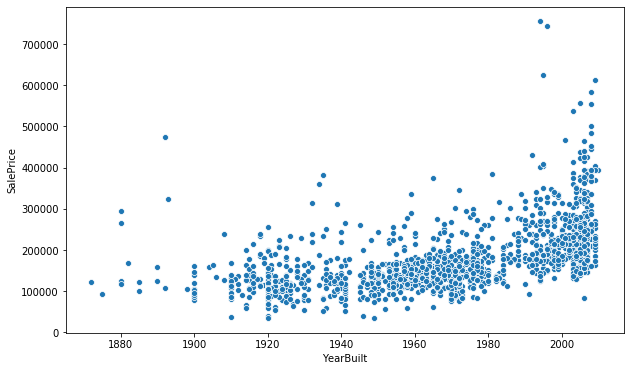

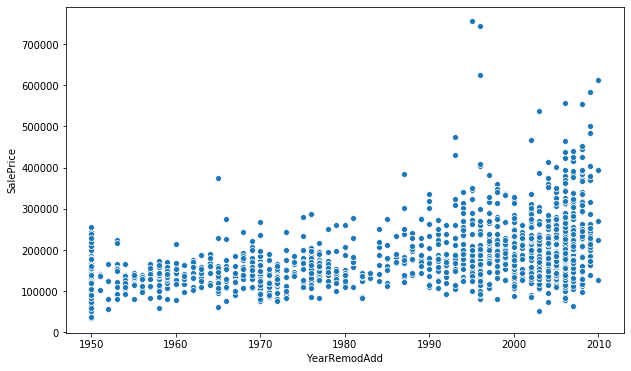

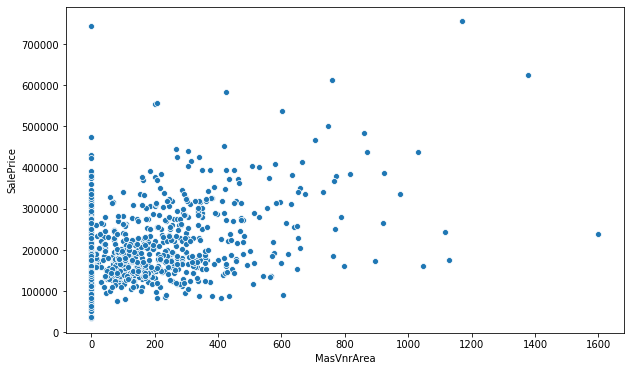

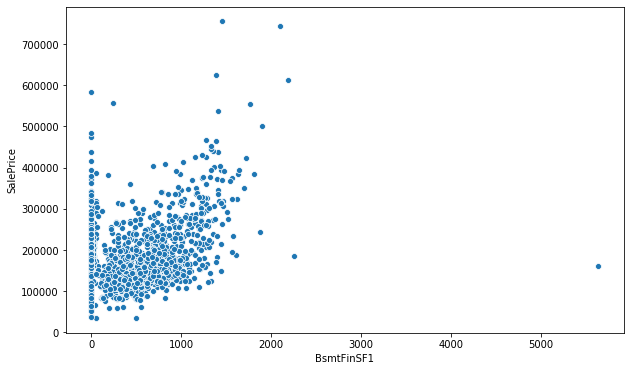

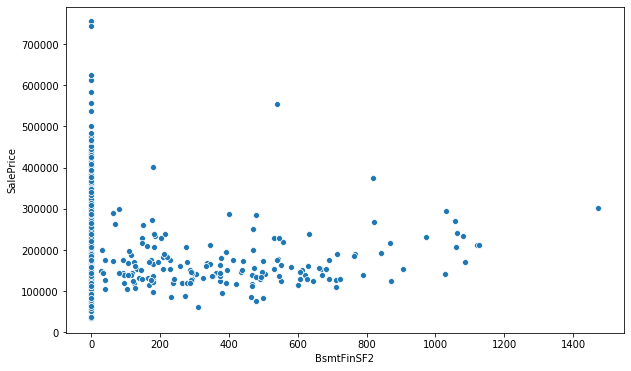

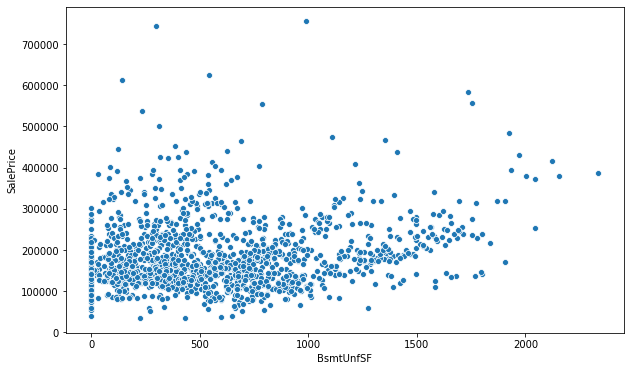

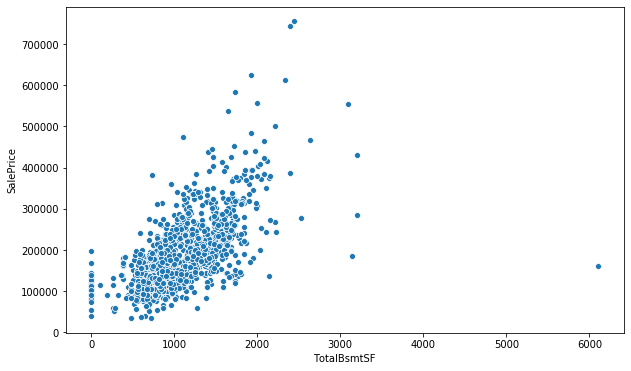

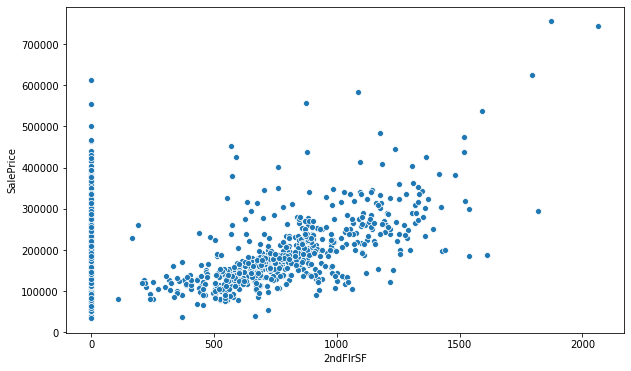

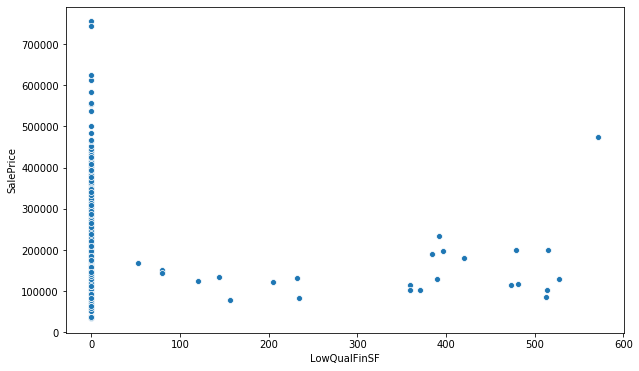

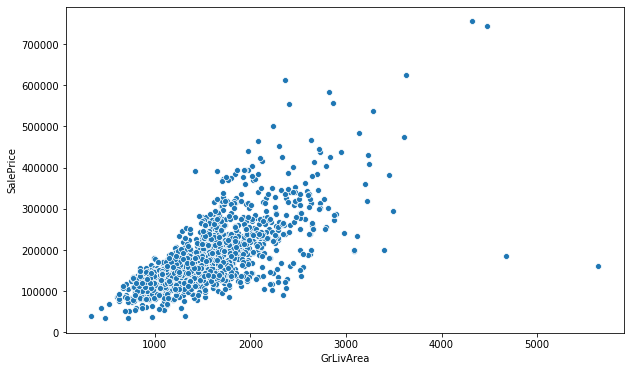

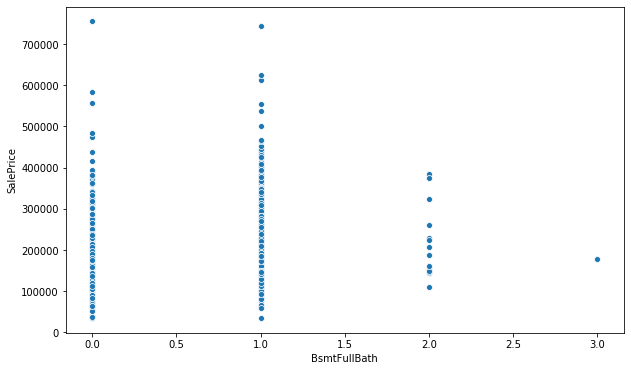

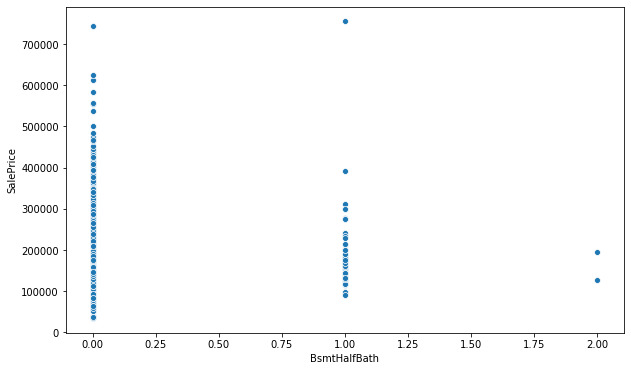

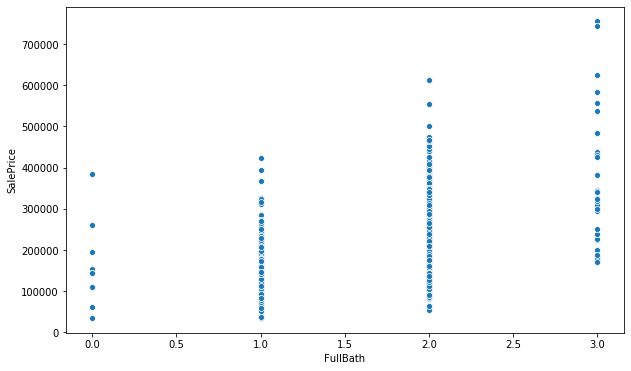

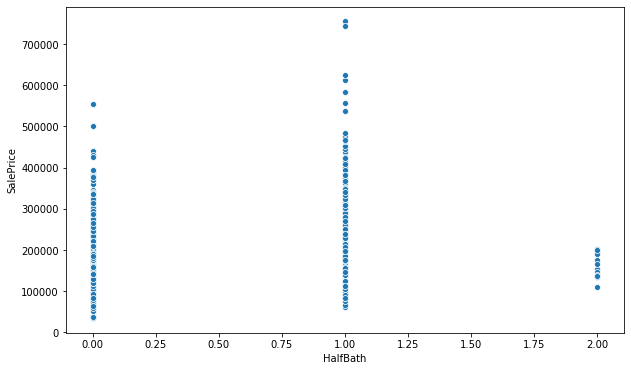

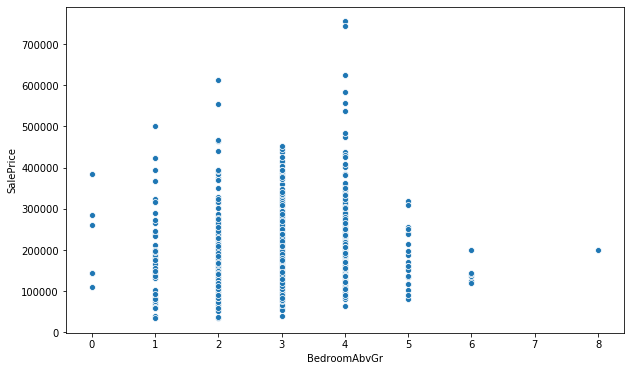

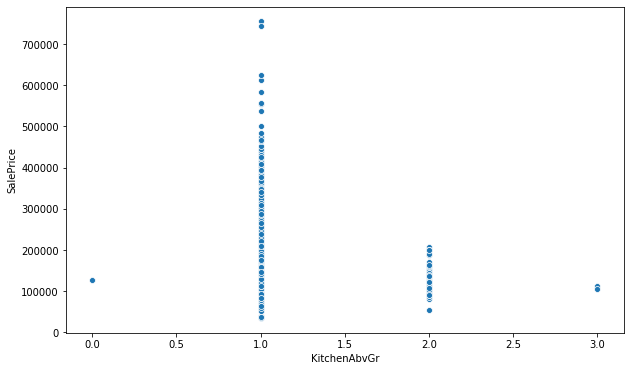

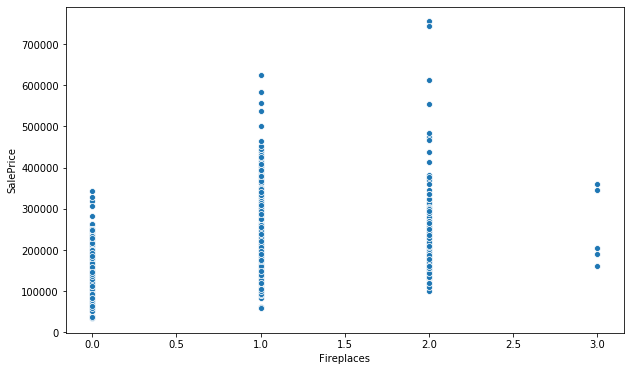

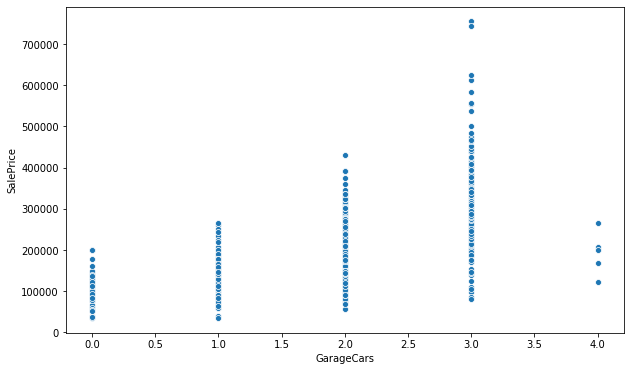

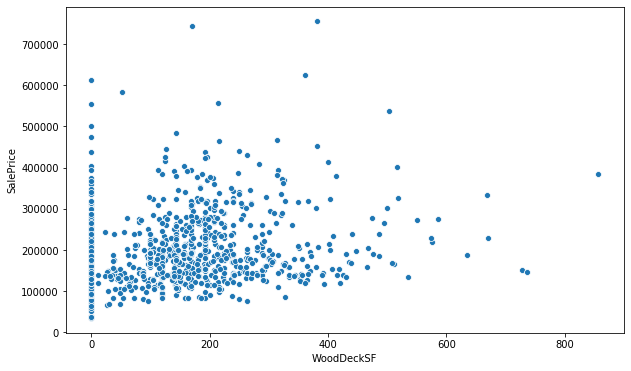

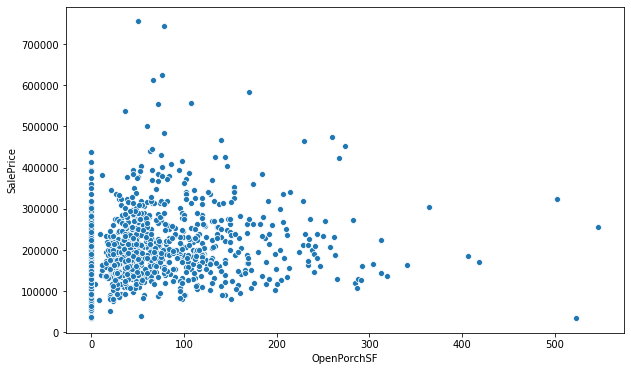

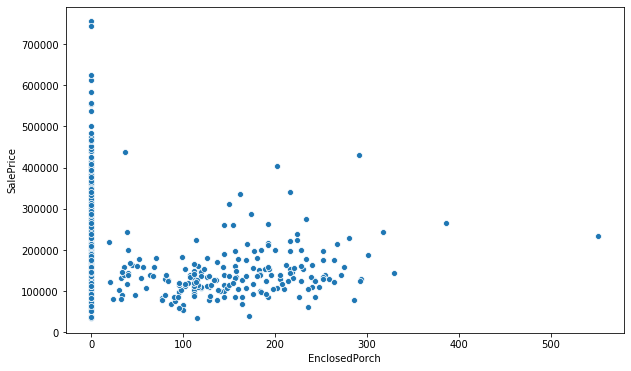

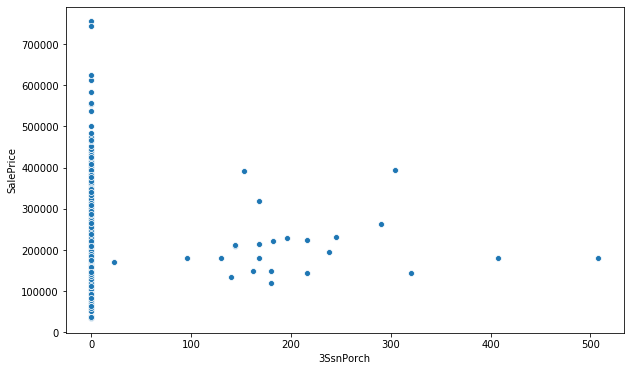

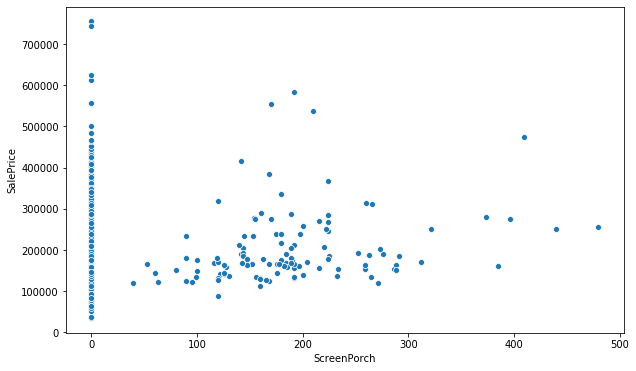

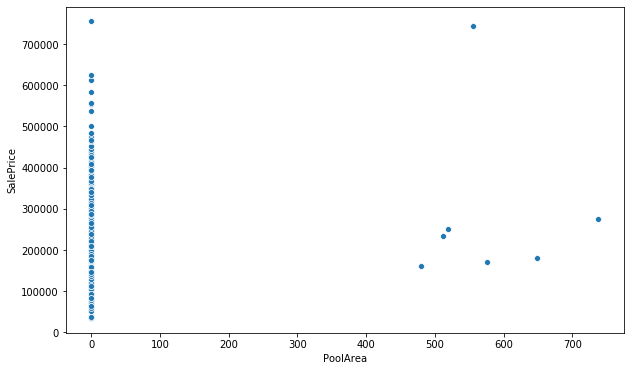

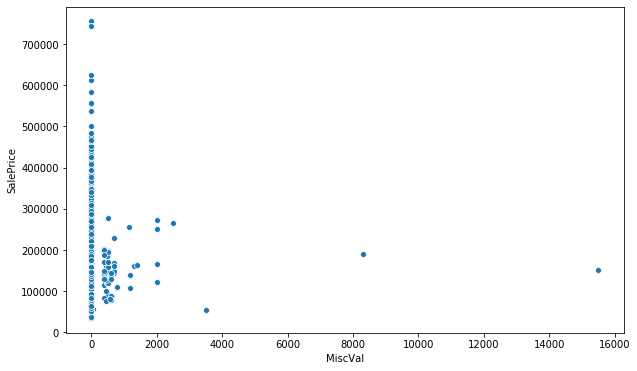

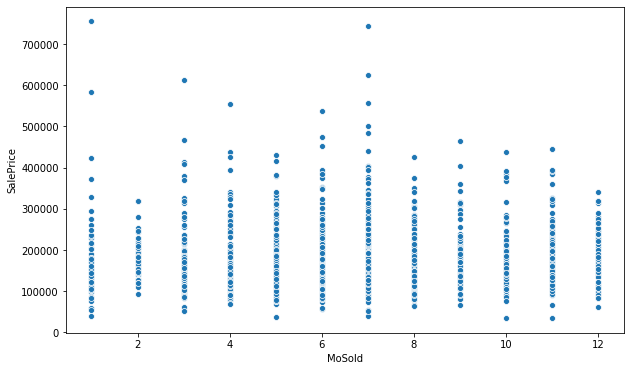

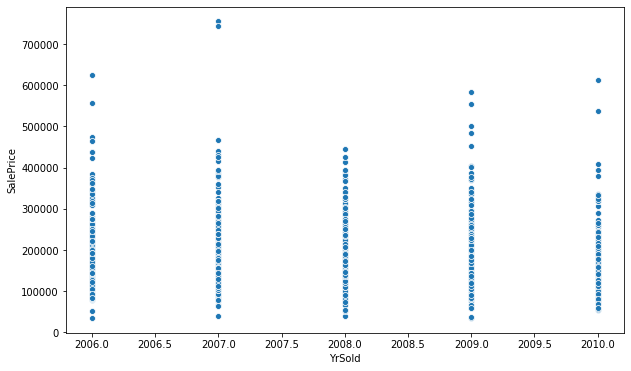

In [10]:
num_cols = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
#Plotting all numeric data to see any outliers
for col in num_cols:
    numeric_plot(data[col],data['SalePrice'])

In [11]:
#Deleting some outliers
data = data[data['LotFrontage'] < 300]
data = data[data['BsmtFinSF1'] < 5000]
data = data[data['TotalBsmtSF'] < 6000]
data = data[data['GrLivArea'] < 4600]
data = data[data['SalePrice'] < 700000]
data = data[data['EnclosedPorch'] < 400]

In [12]:
missing_cols(holdout)

Columns | Percentage missing
MSZoning : 0.27%
LotFrontage : 15.56%
Utilities : 0.14%
Exterior1st : 0.07%
Exterior2nd : 0.07%
MasVnrType : 1.1%
MasVnrArea : 1.03%
BsmtQual : 3.02%
BsmtCond : 3.08%
BsmtExposure : 3.02%
BsmtFinType1 : 2.88%
BsmtFinSF1 : 0.07%
BsmtFinType2 : 2.88%
BsmtFinSF2 : 0.07%
BsmtUnfSF : 0.07%
TotalBsmtSF : 0.07%
BsmtFullBath : 0.14%
BsmtHalfBath : 0.14%
KitchenQual : 0.07%
Functional : 0.14%
FireplaceQu : 50.03%
GarageType : 5.21%
GarageFinish : 5.35%
GarageCars : 0.07%
GarageQual : 5.35%
GarageCond : 5.35%
SaleType : 0.07%


In [13]:
#Using mean to fill the missing data on numeric columns
imputer = SimpleImputer(strategy='mean')
data[num_cols] = imputer.fit_transform(data[num_cols])
holdout[num_cols] = imputer.transform(holdout[num_cols])

In [14]:
missing_cols(holdout)

Columns | Percentage missing
MSZoning : 0.27%
Utilities : 0.14%
Exterior1st : 0.07%
Exterior2nd : 0.07%
MasVnrType : 1.1%
BsmtQual : 3.02%
BsmtCond : 3.08%
BsmtExposure : 3.02%
BsmtFinType1 : 2.88%
BsmtFinType2 : 2.88%
KitchenQual : 0.07%
Functional : 0.14%
FireplaceQu : 50.03%
GarageType : 5.21%
GarageFinish : 5.35%
GarageQual : 5.35%
GarageCond : 5.35%
SaleType : 0.07%


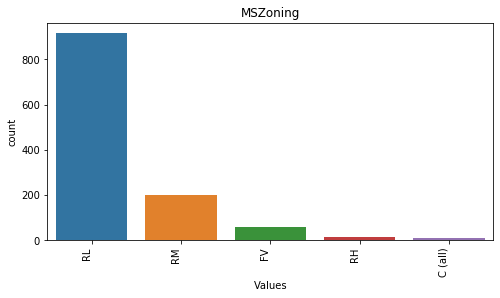

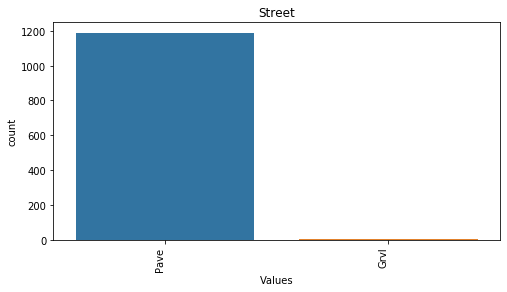

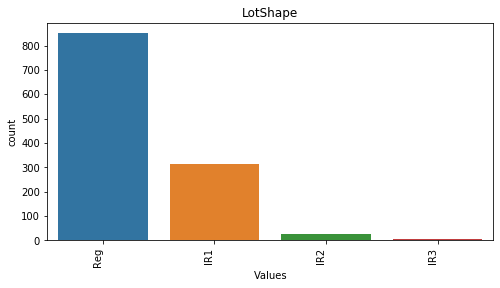

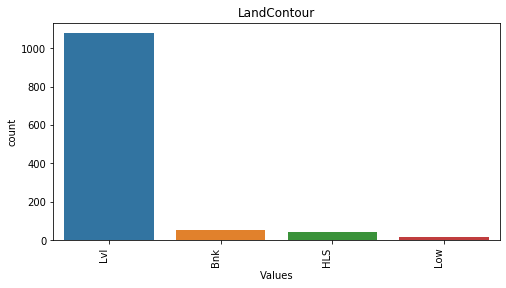

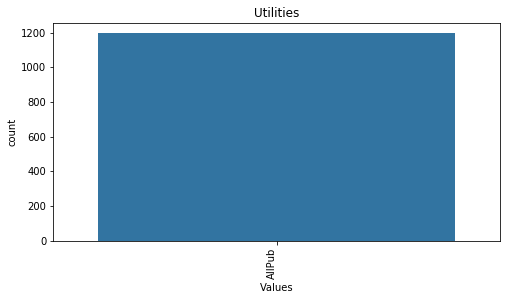

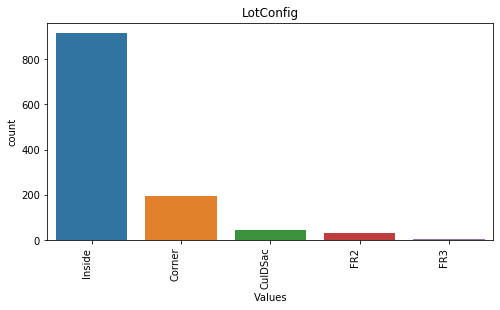

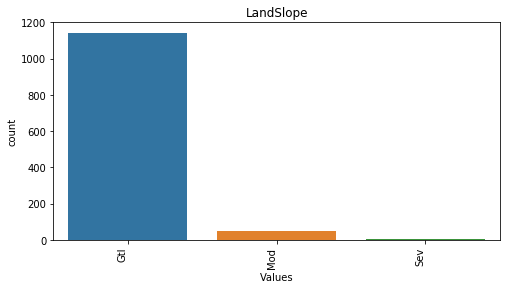

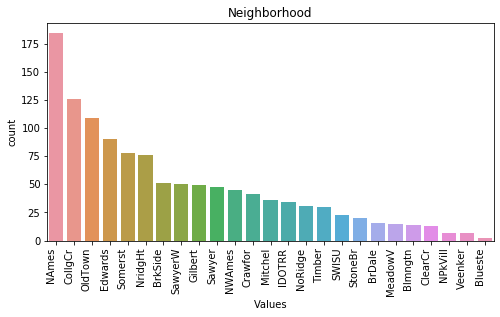

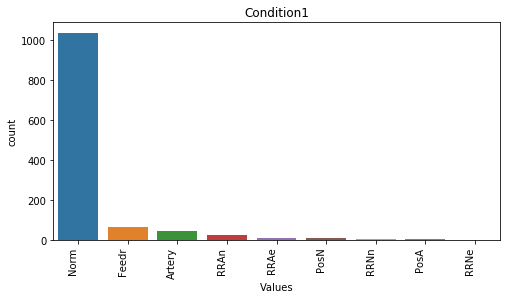

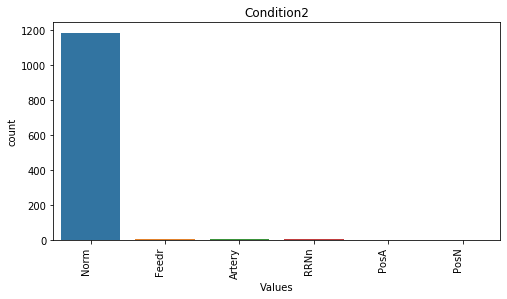

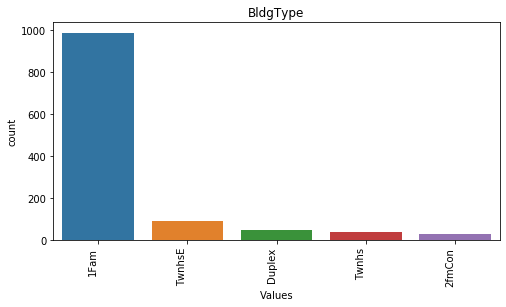

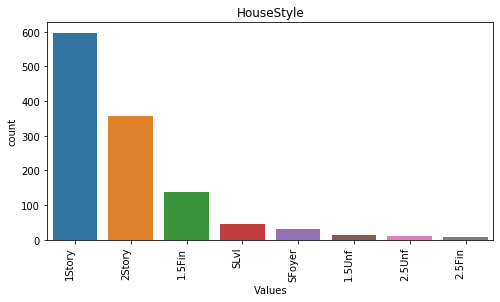

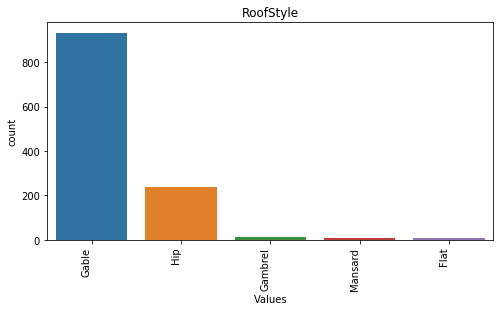

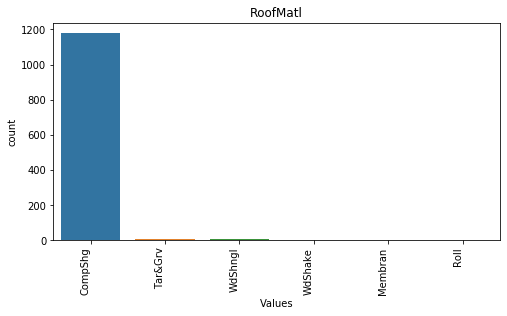

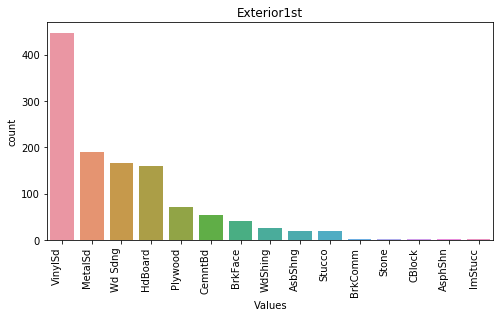

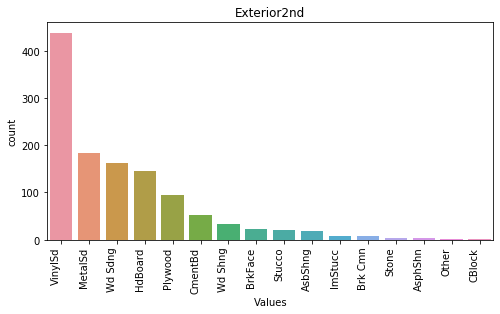

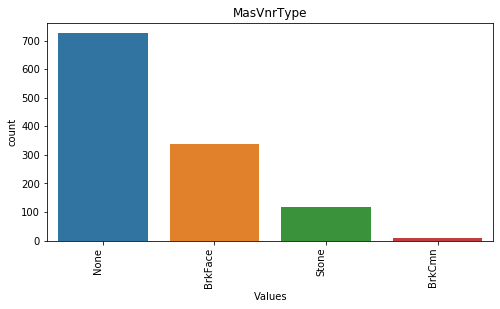

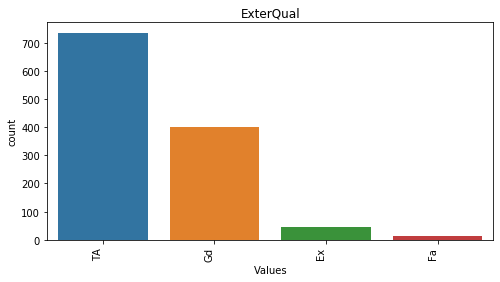

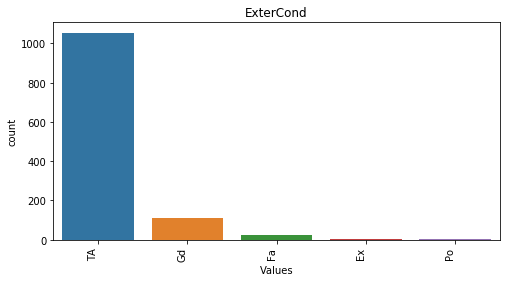

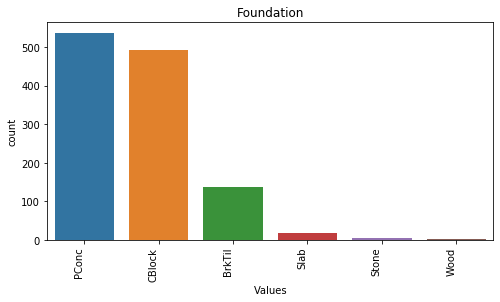

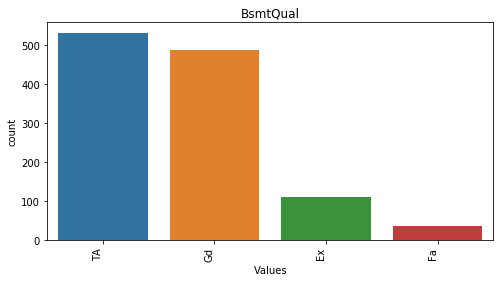

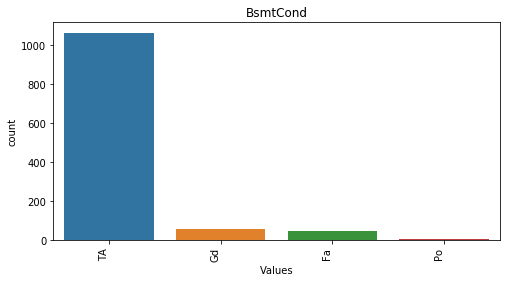

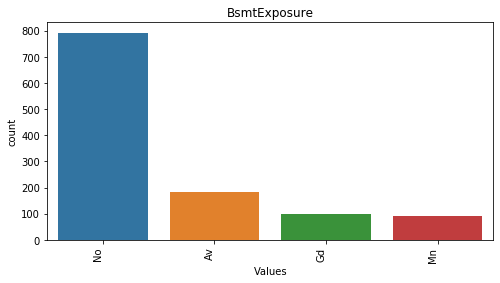

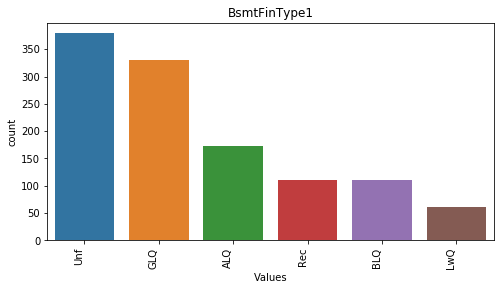

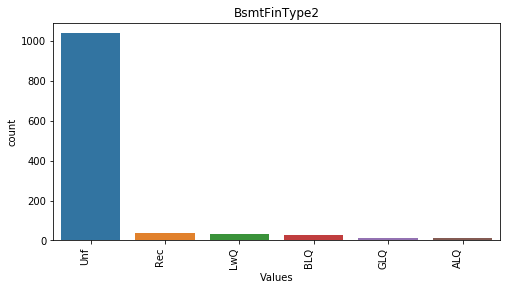

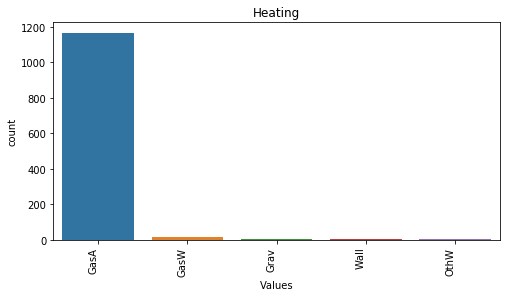

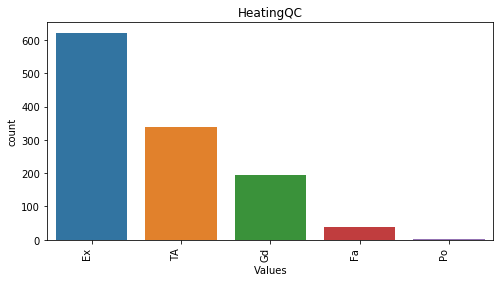

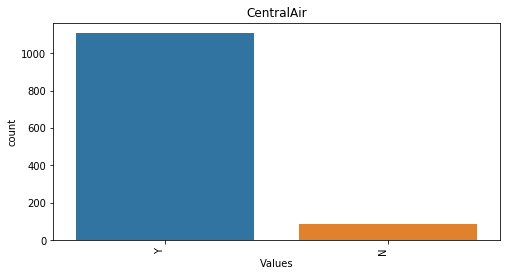

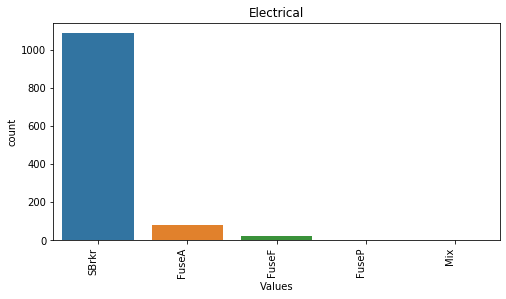

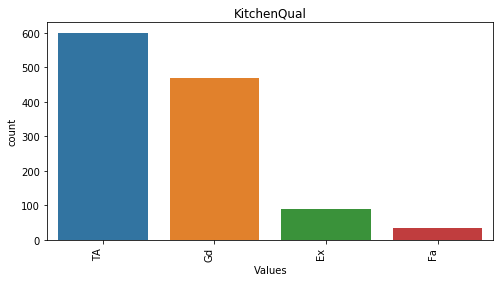

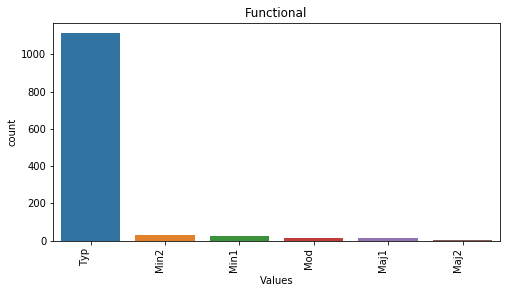

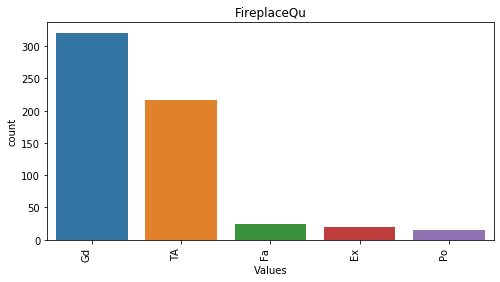

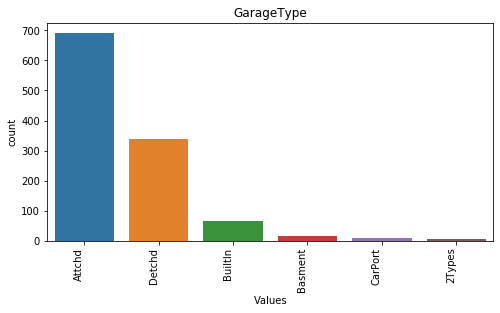

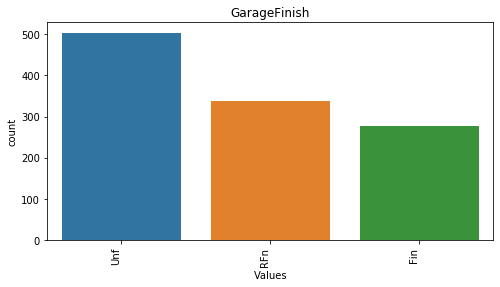

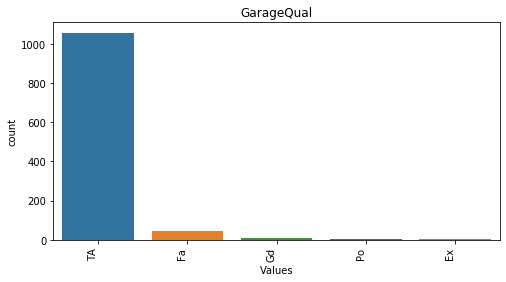

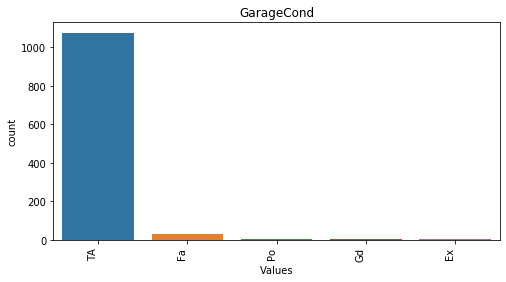

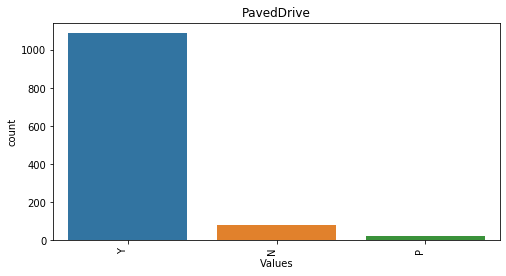

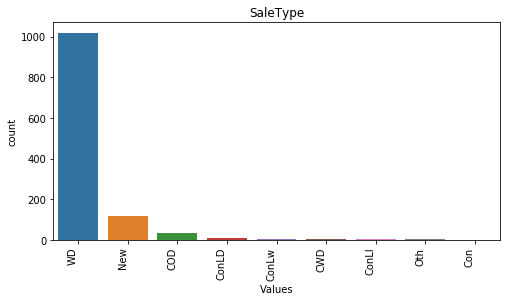

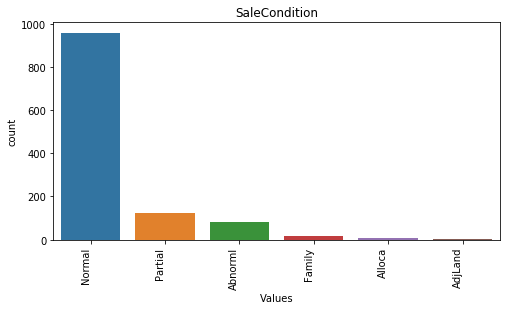

In [15]:
#Plotting Categorical data
for col in data.select_dtypes('object'):
    categories_plot(data,col)

In [16]:
#Deleting some categorical data which don't have variety i.e only one value is dominating
data = data.drop(['Street','Utilities','Condition2','RoofMatl','Heating'],axis=1)
holdout = holdout.drop(['Street','Utilities','Condition2','Heating','RoofMatl'],axis=1)

In [17]:
#Filling missing values using mode for categorical data
for col in data.select_dtypes('object'):
    data[col] = data[col].fillna(data[col].mode()[0])
    holdout[col] = holdout[col].fillna(holdout[col].mode()[0])

In [18]:
#Use dummy encoding with categorical features
all_data = pd.concat([data,holdout],axis=0)
cols_to_lable = all_data.select_dtypes('object').columns
for col in cols_to_lable:
    all_data = create_dummies(all_data,col)
 
all_data = all_data.loc[:,~all_data.columns.duplicated()]
holdout_new = all_data.loc[all_data['SalePrice'].isna()]
data_new = all_data.loc[all_data['SalePrice'].notna()]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop(['SalePrice','Id'],axis=1), data_new.SalePrice, test_size=0.33, random_state=42)

In [20]:
base_learners = {'LinearRegression':LinearRegression(),'KNeighborsRegressor':KNeighborsRegressor(),
          'RandomForestRegressor':RandomForestRegressor(),
          'AdaBoostRegressor':AdaBoostRegressor(),
          'ExtraTreesRegressor':ExtraTreesRegressor(),
          'XGBRegressor':XGBRegressor(),
          'svr':SVR(),'MLPRegressor':MLPRegressor(),
                'GradientBoostingRegressor':GradientBoostingRegressor()}

In [21]:
for model_name in base_learners:
    base_learners[model_name].fit(X_train,y_train)
    pred = base_learners[model_name].predict(X_test)
    
    print(model_name + ':--')
    print('MSE:'+ str(mean_squared_error(y_test,pred)))
    print('MAE:'+str(mean_absolute_error(y_test,pred)))
    print('RMSE:'+str(np.sqrt(mean_squared_error(y_test,pred))))
    print('--------------------------------')

LinearRegression:--
MSE:675143789.5498445
MAE:16869.676120719272
RMSE:25983.52919735586
--------------------------------
KNeighborsRegressor:--
MSE:2489466169.9667845
MAE:31469.730632911396
RMSE:49894.550503705155
--------------------------------
RandomForestRegressor:--
MSE:784662078.5903014
MAE:17942.119443037973
RMSE:28011.820336963134
--------------------------------
AdaBoostRegressor:--
MSE:1130406926.46501
MAE:23739.23342062716
RMSE:33621.52474925862
--------------------------------
ExtraTreesRegressor:--
MSE:794611016.740658
MAE:17276.038202531647
RMSE:28188.845608514337
--------------------------------
XGBRegressor:--
MSE:923239387.2845395
MAE:18402.031744462027
RMSE:30384.854570732103
--------------------------------
svr:--
MSE:8023999884.05609
MAE:59851.081561060644
RMSE:89576.78205905865
--------------------------------


/home/mrutyunjaya/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor:--
MSE:3502214070.615215
MAE:40593.75803026816
RMSE:59179.50718462612
--------------------------------
GradientBoostingRegressor:--
MSE:639150386.4301234
MAE:16039.137002881122
RMSE:25281.42374214956
--------------------------------


In [26]:
#After above model and testing the default results with kaggle with all models, it seems like the best results are from XGboost
#Doing hyperparameter tuing fot XGboost
xgregressor = XGBRegressor()
n_score = cross_val_score(estimator=xgregressor,X=X_train,y=y_train,scoring='neg_mean_absolute_error',n_jobs=-1,cv=10,error_score='raise')
n_score = np.abs(n_score)
print(n_score)

[21117.55390625 18346.17895508 17782.59350586 16604.99814453
 20113.12109375 18381.11176758 22188.09550781 17829.52167969
 20598.06669922 15967.20683594]


In [23]:
booster = ['gblinear','gbtree']
base_score = [0.25,0.5,0.75,1]
n_estimators = [100,500,900,1100,1500]

In [24]:
max_depth = [2,3,5,10,15]
learning_rate = [0.05,0.1,0.15,0.20]
min_child_weight = [1,2,3,4]

In [25]:
hyperparameters = {"booster":booster,
                  "base_score":base_score,
                  'n_estimators':n_estimators,
                  'max_depth':max_depth,
                  'learning_rate':learning_rate,
                  'min_child_weight':min_child_weight}

In [ ]:
#doing Randomizedsearch since my laptop is too slow for gridsearch?
random = RandomizedSearchCV(estimator=XGBRegressor(),param_distributions=hyperparameters,scoring='neg_mean_absolute_error',
                   cv=5,n_jobs=3,verbose=5,return_train_score=True,n_iter=50)
random.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.7min


In [ ]:
y_pred = random.predict(X_test)

In [ ]:
random.fit(data_new.drop(['SalePrice','Id'],axis=1),data_new.SalePrice)

In [ ]:
holdout_pred = random.predict(holdout_new.drop(['SalePrice','Id'],axis=1))
submission = pd.DataFrame({'Id':holdout_new.Id,'SalePrice':holdout_pred})
submission.to_csv('submission_10.csv',index=False)